In [1]:
import os 
import glob
import zipfile
import dolfyn as dlfn
import xarray as xr
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.dates as mdates
from pathlib import Path
from dolfyn.adp import api
from matplotlib import pyplot as plt
import matplotlib.dates as dt

## READ AD2CP FILES AND MERGE
1. Change file extensions to zip from sigVM 
2. Extrct data from zip files
3. Read the data and merge the data sets
4. save in netCDF format

In [2]:
wdir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','process-raw')
zdir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','process-raw','zipped-files')
indir    = os.path.join(wdir + '/*.sigVM')

# deal with the file formats. Change file extensions to zip from sigVM and unzip
fname =glob.glob(indir)

# check for zip files and if not there then create them
if fname:
    for i in fname:
        print(i)
        bn = os.path.splitext(os.path.basename(i))[0]
        old=i
        new=os.path.join(zdir,bn+'.zip')
        os.rename(old, new)
        
indir    = os.path.join(zdir + '/*.zip')        
fname =glob.glob(indir)

# extract any zip files
if fname:
    for i in fname:
        with zipfile.ZipFile(i,"r") as zip_ref:
            zip_ref.extractall(zdir)

# GET ALL AD2CP FILES 
ad2cpdir= os.path.join(zdir + '/*.AD2CP')
fname =glob.glob(ad2cpdir)

# GET ALL NMEA FILES
ndir     = os.path.join('c:/','Users','sa01ld','OneDrive - SAMS','Projects','Autonaut-EE', 'Non-Acoustic data','batch-process-GNSS')
nmdir    = os.path.join(ndir + '/*_Data')
nmname =glob.glob(nmdir)


# mergring starts here
first=True
xx=0
adppath = Path('data/ADCP.nc')
navpath = Path('data/nav.csv')

if not adppath.is_file():
    for i,j in zip(fname,nmname):
            # bad files check
            if i in ['c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20211008T190648UTC.AD2CP','c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20211008T130648UTC.AD2CP','c:/Users\\sa01ld\\OneDrive - SAMS\\Projects\\Autonaut-EE\\Non-Acoustic data\\process-raw\\zipped-files\\101512_20210805T010703UTC.AD2CP']:
                bn = os.path.splitext(os.path.basename(i))[0] # unique file ID
                print('skipping ' + bn)
                continue

            # read csv files and extract lat and long data
            bn = os.path.splitext(os.path.basename(i))[0] # unique file ID
            print('Checking ' + bn)

            if not navpath.is_file():
                csvpath=os.path.join(j,bn+'.csv')
                df=pd.read_csv(csvpath) # nav data 


                asv=np.square(df.GPSEast.values)+np.square(df.GPSNorth.values)
                asv=np.sqrt(asv) 

                adcp=np.square(df.VEast.values)+np.square(df.VNorth.values)
                adcp=np.sqrt(adcp) 
                time=df.Date_Time
                timex = np.array(time, dtype='datetime64[s]')

                # make new dataframe
                ndf = df[['Date_Time', 'EnsNo','GPSEast','GPSNorth','GPSHeading', 'SHeading','VEast','VNorth']].copy()
                ndf.insert(1, "adcpVel", adcp,allow_duplicates=True)
                ndf.insert(1, "asvVel", asv,allow_duplicates=True)
                if xx>0:
                    # concatenate the datframes
                    csdf=pd.concat([csdf, ndf])
                else:
                    csdf=ndf

                xx=xx+1  
            
            da = dlfn.read(i) # adcp data  
            da = dlfn.rotate2(da, 'earth', inplace=True)

            # merge the ADCP dat sets
            if first:
                first = False
                ds=da
            else:
                ds=xr.merge([ds,da])
    # save to net cdf       
    ds.to_netcdf(path='data/ADCP.nc')
    csdf.to_csv('data/nav.csv', index=False)
    
else:
    ds = xr.open_dataset('data/ADCP.nc')
    csdf = pd.read_csv('data/nav.csv') # nav data 
        

In [3]:
ds.attrs['fs'] = 1
ds.attrs['coord_sys'] = 'earth'
ds.attrs['inst_make'] = 'Nortek'
ds.attrs['inst_model'] = 'Signature500'
ds.attrs['orientation'] = 'down'

dlfn.set_declination(ds, declin=3.4) # 3.4 deg west
dlfn.rotate2(ds, 'earth', inplace=True)

ds.attrs['principal_heading'] = dlfn.calc_principal_heading(ds.vel.mean('range'))
avg_tool = api.VelBinner(n_bin=ds.fs*5, fs=ds.fs)
ds_avg = avg_tool.do_avg(ds)


Data is already in the earth coordinate system


In [29]:
ds_avg.to_netcdf(path='data/ADCP_avg.nc')


In [17]:
np.mean(x,axis=0)

<xarray.DataArray 'vel' (time: 70153)>
array([ 0.76243137,  0.15984378, -0.60658231, ..., -0.07857176,
       -0.08583738, -0.17036639])
Coordinates:
  * time     (time) float64 1.628e+09 1.628e+09 ... 1.634e+09 1.634e+09
    dir      <U1 'E'

In [18]:
x=ds_avg.vel.sel(dir='E')
x=np.mean(x,axis=0)
y=ds_avg.vel.sel(dir='N')
y=np.mean(y,axis=0)
r = np.sqrt(x**2+y**2)
t = np.arctan2(y,x)
ds_avg['current_speed']=r
ds_avg['current_bearing'] = t


4770404

AttributeError: 'AxesSubplot' object has no attribute 'set_clim'

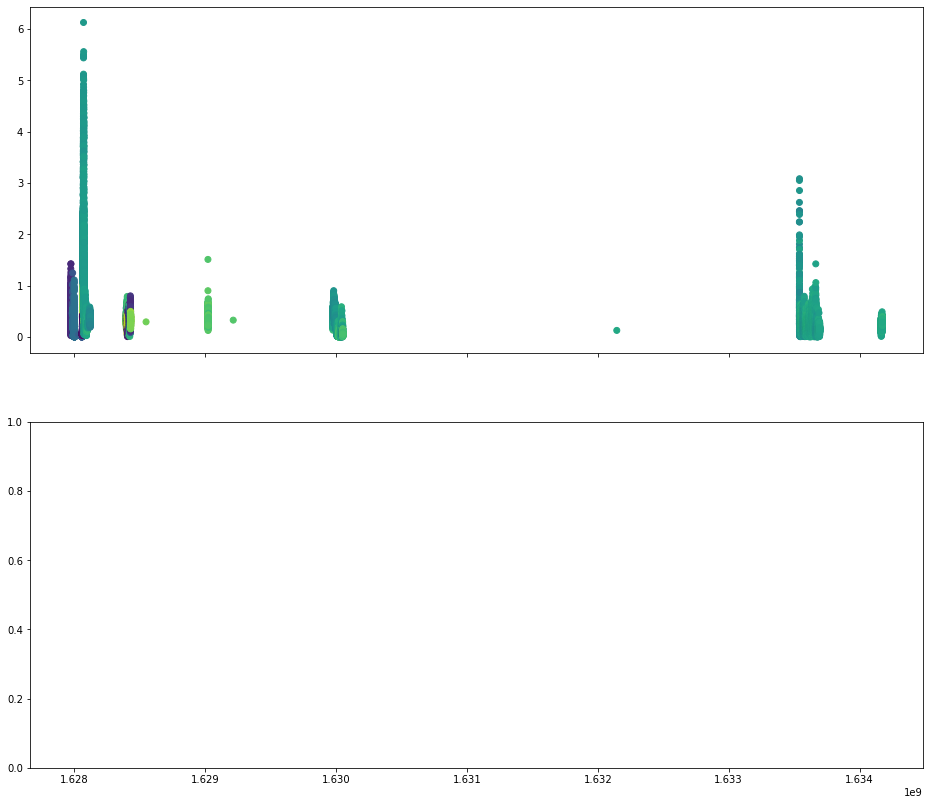

In [27]:
%matplotlib inline
fig, ax = plt.subplots(2,1,figsize=(16,14), sharex=True)
ax = ax.ravel()
ax[0].scatter(ds_avg.time.data, ds_avg.current_speed.data, c=ds_avg.heading.data, vmin=0, vmax=360)
ax[0].set_clim(vmin=0, vmax=100)
plt.colorbar(ax[0])
fig.autofmt_xdate()

In [110]:
ds_avg.time.data

array([1.62797418e+09, 1.62797448e+09, 1.62797478e+09, ...,
       1.63417355e+09, 1.63417385e+09, 1.63417415e+09])

In [80]:
ds_avg['U_mag'] = ds_avg.vel.U_mag

ds_avg['U_dir'] = ds_avg.vel.U_dir
ds_avg['U_dir'].data = dlfn.tools.misc.convert_degrees(ds_avg['U_dir'].values, tidal_mode=True)


# surface current values
dv_east=np.mean(ds.vel.sel(dir='E', range=slice(0,5)).values,axis=0)
dv_north=np.mean(ds.vel.sel(dir='N', range=slice(0,5)).values,axis=0)
dv_time=ds.time.values+3600
dv_time = np.array(dv_time, dtype='datetime64[s]')



ev=np.square(dv_east)+np.square(dv_north)
ev=np.sqrt(ev) 

nav_time=np.array(csdf.Date_Time)
adp_time=dv_time

AttributeError: 'DataArray' object has no attribute 'U_mag'

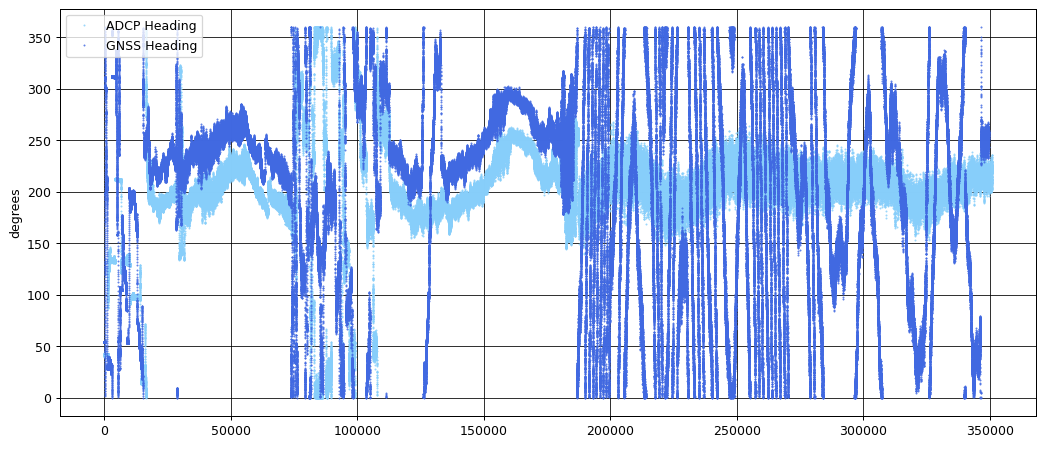

In [51]:
fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
plt.plot(ds.heading_bt.values,'.',
         markersize=1,
         color='lightskyblue',
         label="ADCP Heading")

plt.plot(csdf.GPSHeading.values,'.',
         markersize=1,
         color='royalblue',
         linewidth=1.0, label="GNSS Heading")

plt.xlabel(" ")
plt.ylabel("degrees")               
plt.legend(loc='upper left')
plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
figfile=os.path.join('figures/' +'headings.png')
fig.savefig(figfile, dpi=100, facecolor='white')
plt.show()

                

        

# Plot the data

NameError: name 'timex' is not defined

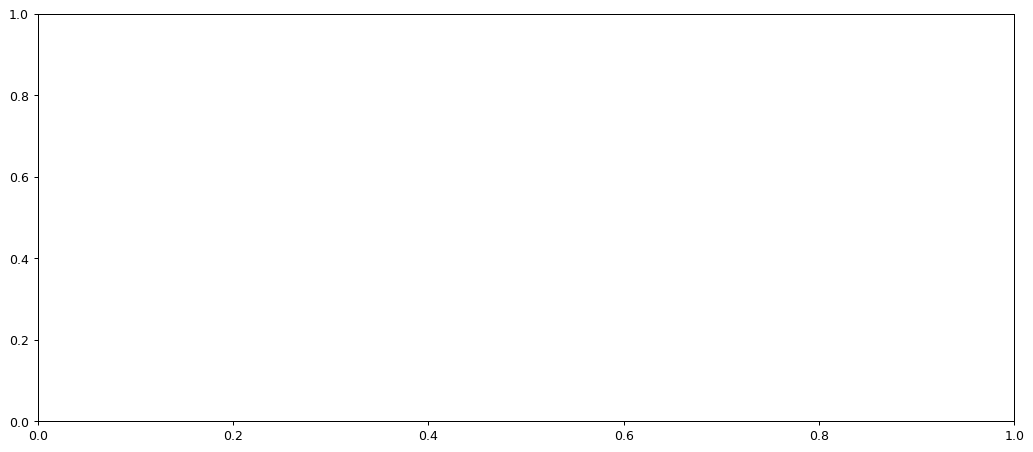

In [99]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
plt.plot(asv, label="GPS Velocity")
plt.plot(timex,adcp, label="ADCP Velocity")
plt.xlabel("Time")
plt.ylabel("m/s")
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1000)) 
plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
fig.autofmt_xdate()
figfile=os.path.join('figures/' +'gps_speed_vs_adcp_speed_processed'+ bn + '.png')
fig.savefig(figfile, dpi=100, facecolor='white')
plt.show()

In [ ]:
da.ensemble.values

In [ ]:
not xx

In [100]:
# get moving average
a_series = pd.Series(ev)
rolling_window_obj = a_series.rolling(50)
ra_ev = rolling_window_obj.mean()
ra_ev.size

a_series = pd.Series(asv)
rolling_window_obj = a_series.rolling(50)
ra_asv = rolling_window_obj.mean()
ra_asv.size


NameError: name 'asv' is not defined

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[14, 6], sharex=True, dpi=90)
plt.plot(timex,asv, label="GPS Velocity")
plt.plot(dv_time,ev, label="earth-rotated ADCP Velocity")
plt.plot(timex,ra_asv, color='yellow', linestyle='dashed', linewidth=2,label="ship velocity moving average")
plt.plot(dv_time,ra_ev, color='black', linestyle='dashed', linewidth=2,label="adcp velocity moving average")
plt.xlabel("Time")
plt.ylabel("m/s")
plt.legend(loc='upper left')
plt.grid(visible='True', which='major', axis='both', c='black',alpha=0.8)
fig.autofmt_xdate()
#                 ax.set_xlim([datetime.date(2021, 8, 27), datetime.date(2021, 8, 28)])
figfile=os.path.join('figures/' +'gps_speed_vs_earth-rotated-adcp_speed_processed'+ bn + '.png')
fig.savefig(figfile, dpi=100, facecolor='white')
plt.show()

In [ ]:
# try integrate the values for a depth average
v_east=da.vel.sel(dir='E').values
z=da.range.values
dz=np.diff(z)
v_east=v_east.T
dac=np.trapz(v_east,x=z)
plt.plot(dac)

In [ ]:
# some fake data
data = ds.corr
# evaluate the histogram
values, base = np.histogram(data, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')
#plot the survival function
plt.plot(base[:-1], len(data)-cumulative, c='green')

plt.show()

In [ ]:
%matplotlib inline
ds.vel.sel(dir=1, range=slice(0,70)).plot()

Earth: When the data object is in ‘earth’ coordinates, the first dimension of vectors are: [East, North, Up, …]. This coordinate system is also sometimes denoted as “ENU”. If the declination is set the earth coordinate system is “True-East, True-North, Up” otherwise, East and North are magnetic. See the Declination Handling section for further details on setting declination.

In [ ]:
bn

In [ ]:
Evel=dd.vel.sel(dir=1,range=5)
Nvel=dd.vel.sel(dir=2,range=5)


In [ ]:
%matplotlib inline
ds.corr.sel(beam=1, range=slice(0,70)).plot()

In [ ]:
ds = api.clean.correlation_filter(ds, thresh=50)

%matplotlib inline
ds.corr.sel(beam=1, range=slice(0,70)).plot()

In [ ]:
ds_avg['U_mag'] = ds_avg.velds.U_mag
ds_avg['U_dir'] = ds_avg.velds.U_dir
ds_avg['U_dir'].data = dlfn.tools.misc.convert_degrees(ds_avg['U_dir'].values, tidal_mode=True)

%matplotlib inline
ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot the horizontal velocity magnitude
t = dlfn.time.dt642date(ds_avg.time)
plt.pcolormesh(t, ds_avg.range, ds_avg['U_mag'], cmap='Blues', shading='nearest')
# Plot the water surface
ax.plot(t, ds_avg.depth)

# Set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 12])
plt.colorbar(label='Horizontal Vel [m/s]')